# DEMO: Missingness module

This notebook provides a demo of how to utilise the missingness module.

In [1]:
import sys
sys.path.append('../../')

import numpy as np
import pandas as pd
import niimpy
from niimpy.EDA import EDA_missingness

## Load data
We will create a mock missingess dataframe.

In [2]:
df = niimpy.util.create_missing_dataframe(nrows=2*24*14, ncols=5, density=0.5, index_type='dt', freq='10T')
df

,0,1,2,3,4
2022-01-01 00:00:00,76.625922,NaN,NaN,NaN,83.034488
2022-01-01 00:10:00,NaN,NaN,NaN,13.470172,NaN
2022-01-01 00:20:00,71.979257,NaN,NaN,NaN,NaN
2022-01-01 00:30:00,19.878556,NaN,60.896054,73.557393,91.239731
2022-01-01 00:40:00,90.093160,3.696112,92.583761,NaN,NaN
...,...,...,...,...,...
2022-01-05 15:10:00,63.051738,NaN,68.875268,78.223166,79.899777
2022-01-05 15:20:00,56.596313,NaN,NaN,25.001357,64.313606
2022-01-05 15:30:00,69.383316,53.895055,NaN,21.146107,28.734343
2022-01-05 15:40:00,NaN,57.632242,77.380775,NaN,17.992380


## Visualization

First, we create a histogram to visualize data frequency per column.

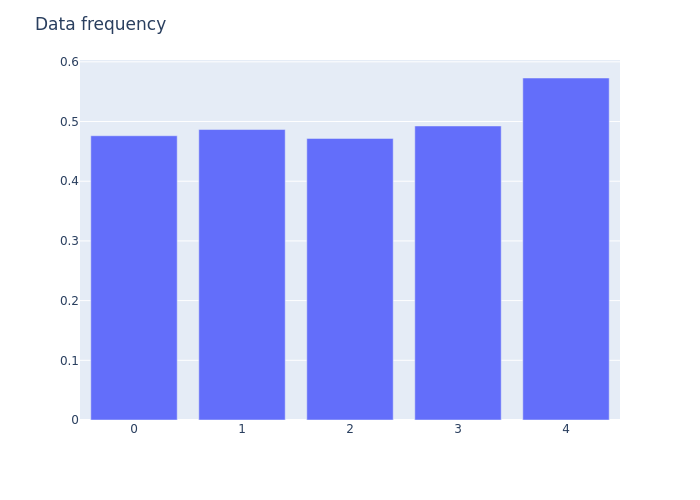

In [3]:
fig = EDA_missingness.bar(df)
fig.show('png')

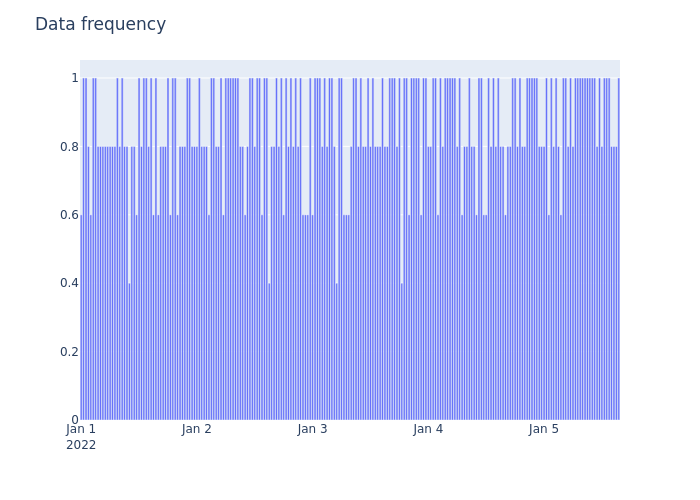

In [4]:
fig = EDA_missingness.bar(df, sampling_freq='30T')
fig.show('png')

We can also create a missingness matrix visualization for the dataframe.

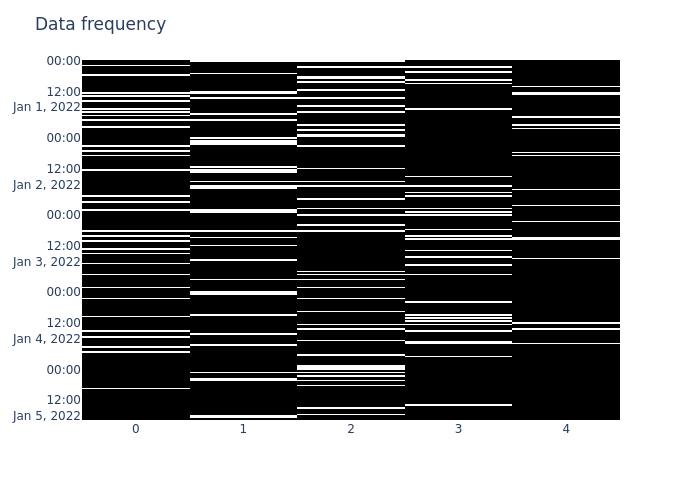

In [5]:
fig = EDA_missingness.matrix(df, sampling_freq='30T')
fig.show('png')

Finally, we can plot a heatmap to display the correlation between missing data.

Correlation ranges from -1 to 1. -1 means that if one variable appears then the other will definitely not. 0 means that there is no correlation between the missingness of two variables. 1 means that the two variables will always appear together.

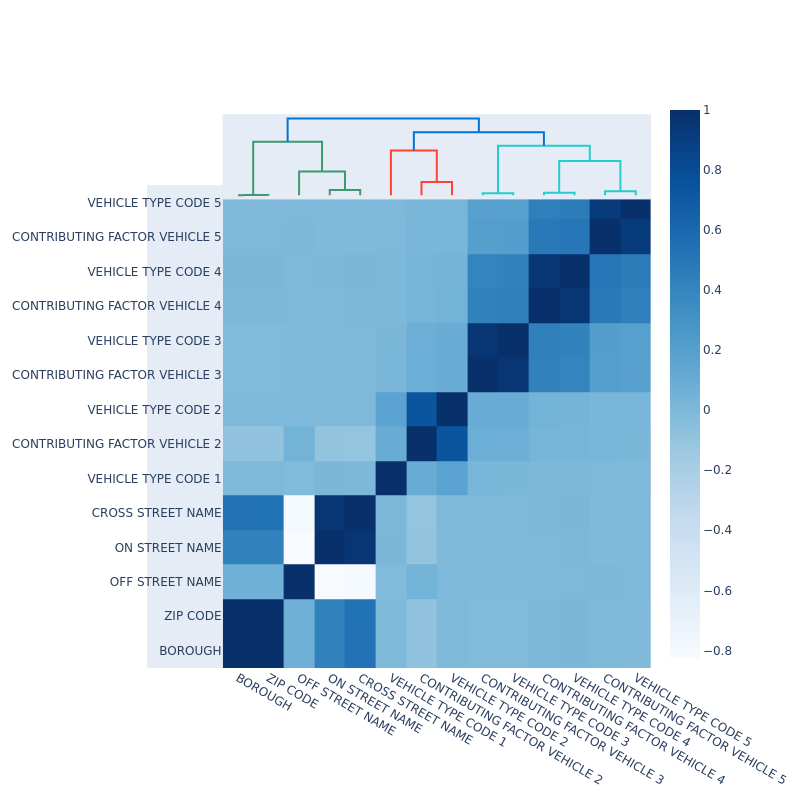

In [6]:
import plotly.graph_objects as go
import plotly.figure_factory as ff

import numpy as np
#from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform


def heatmap(df, height=800, width=800):
    ''' Return 'plotly' heatmap visualization of the nullity correlation of the Dataframe.
    
    :param df: DataFrame to plot
    
    :return: Plotly figure
    '''
    
    # Remove completely filled or completely empty variables.
    df = df.iloc[:, [i for i, n in enumerate(np.var(df.isnull(), axis='rows')) if n > 0]]

    # Create and mask the correlation matrix. Construct the base heatmap.
    corr_mat = df.isnull().corr()
    
    # Calculate dissimilarity distance. 
    # Dissimilarity is close to zero if correlation is close to 1 or -1. 
    dissimilarity = 1 - abs(corr_mat)
    labels = df.columns

    # Initialize figure by creating upper dendrogram
    fig = ff.create_dendrogram(dissimilarity, orientation='bottom', labels=labels)
    for i in range(len(fig['data'])):
        fig['data'][i]['yaxis'] = 'y2'

    # Create Side Dendrogram
    dendro_side = ff.create_dendrogram(dissimilarity, orientation='right', labels=labels)
    dendro_side.for_each_trace(lambda trace: trace.update(visible=False))
    for i in range(len(dendro_side['data'])):
        dendro_side['data'][i]['xaxis'] = 'x2'

    # Add Side Dendrogram Data to Figure
    for data in dendro_side['data']:
        fig.add_trace(data)

    # Create Heatmap
    dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
    dendro_vals =  dendro_side['layout']['yaxis']['tickvals']

    heat_data = corr_mat.reindex(columns=dendro_leaves)
    heat_data = heat_data.reindex(dendro_leaves)
    
    heatmap = [
        go.Heatmap(
            x = dendro_leaves,
            y = dendro_leaves,
            z = heat_data,
            colorscale = 'Blues'
        )
    ]

    heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']
    heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']

    # Add Heatmap Data to Figure
    for data in heatmap:
        fig.add_trace(data)
    
    # Edit Layout
    fig.update_layout({'width':width, 
                       'height':height,
                       'showlegend':False, 
                       'hovermode': 'closest'})
    # Edit xaxis
    fig.update_layout(xaxis={'domain': [.15, 1],
                              'mirror': False,
                              'showgrid': False,
                              'showline': False,
                              'zeroline': False,
                              'ticks':""})
    # Edit xaxis2
    fig.update_layout(xaxis2={'domain': [0, .15],
                               'mirror': False,
                               'showgrid': False,
                               'showline': False,
                               'zeroline': False,
                               'showticklabels': False,
                               'ticks':""})

    # Edit yaxis
    fig.update_layout(yaxis={'domain': [0, .85],
                             'mirror': False,
                             'showgrid': False,
                             'showline': False,
                             'zeroline': False,
                             'ticks': "",
                             'tickmode': 'array',
                             'ticktext': dendro_leaves,
                             'tickvals': dendro_vals})
    # Edit yaxis2
    fig.update_layout(yaxis2={'domain':[.825, .975],
                               'mirror': False,
                               'showgrid': False,
                               'showline': False,
                               'zeroline': False,
                               'showticklabels': False,
                               'ticks':""})

    return fig

collisions = pd.read_csv("https://raw.githubusercontent.com/ResidentMario/missingno-data/master/nyc_collision_factors.csv")

fig = heatmap(collisions)
fig.show('png')